# Importing necessary packages.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import matplotlib.cm as cm
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg
import random
import itertools

In [2]:
from math import ceil
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from IPython.display import Image, display

%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Import Dataset

In [3]:
input_path = 'F:\Deep Learning Project'

# Exploratory analysis

Files and how the images are stored


In [4]:
print(os.listdir('F:\Deep Learning Project'))

['.ipynb_checkpoints', 'chest_xray', 'Images', 'Pneumonia_detection_using_Chest_Xrays.ipynb']


# Train , Validation , Test

In [5]:
train_dir=input_path + "/chest_xray/chest_xray/train/"
val_dir=input_path + "/chest_xray/chest_xray/val/"
test_dir=input_path + "/chest_xray/chest_xray/test/"

In [6]:
os.listdir(train_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

In [7]:
data_dir = train_dir
from tensorflow import keras
keras.utils.load_img
from keras.preprocessing.image import ImageDataGenerator
class_names=os.listdir(train_dir)
class_names = class_names[1:]
print(class_names)

['NORMAL', 'PNEUMONIA']


# Viewing Dataset 

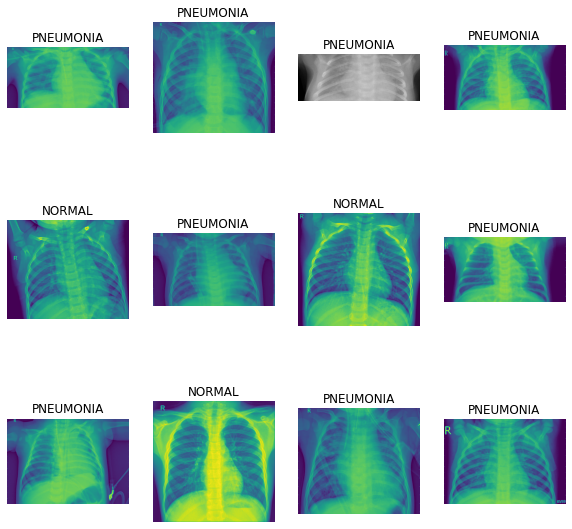

In [8]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    return img
import random
plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    r=random.randint(0,1)
    img = view_random_image(data_dir, class_names[r]) 

# Classes of Dataset

Image distribution among classes 


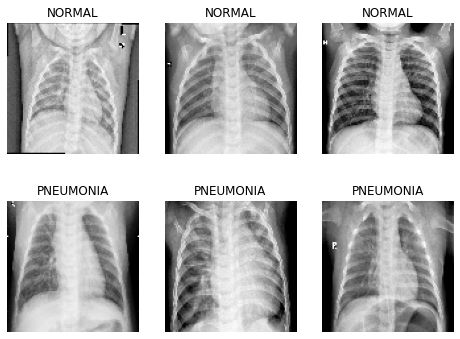

Number of normal images: 1341
Number of pneumonia images: 3875


In [9]:
normal_imgs = [x for x in os.listdir(f'{train_dir}/NORMAL') if x.endswith('.jpeg')]
pneumo_imgs = [y for y in os.listdir(f'{train_dir}/PNEUMONIA') if y.endswith('.jpeg')]

select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)

fig = plt.figure(figsize = (8,6))

for i in range(6):
    if i < 3:
        im_path = f'{train_dir}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        im_path = f'{train_dir}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    
    ax = fig.add_subplot(2, 3, i+1)
    
    im = tf.keras.preprocessing.image.load_img(im_path, target_size = (100,100), color_mode='grayscale')
    plt.imshow(im, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')

plt.show()

print(f'Number of normal images: {len(normal_imgs)}')
print(f'Number of pneumonia images: {len(pneumo_imgs)}')


In [10]:
SEED = 0
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
tf.random.set_seed(SEED)
np.random.seed(SEED)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


# Data Augmentation

In [11]:
from tensorflow.keras import models,layers

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2,0.3),

])

train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building 

## VGG16

In [12]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=2,
    restore_best_weights=True,
)

In [13]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications

base_model =applications.VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
model_Inc = Sequential(resize_and_rescale)
model_Inc.add(base_model)
model_Inc.add(GlobalAveragePooling2D())
model_Inc.add(Dropout(0.5))
model_Inc.add(Dense(64, 
                    activation='relu'))
model_Inc.add(Dense(16, 
                    activation='relu'))
model_Inc.add(Dense(2, 
                    activation='softmax'))
model_Inc.build(input_shape=(32,224,224,3))

model_Incep = model_Inc
LR = 0.001

model_Incep.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
                metrics=["accuracy"])

## Model.fit()

In [14]:
EPOCHS = 5
history = model_Incep.fit(train_data,
                      validation_data=valid_data,
                      epochs=EPOCHS,
                      verbose=True,
                      callbacks=[early_stopping]
                      )

Epoch 1/5
163/163 [==============================] - 1467s 9s/step - loss: 0.4472 - accuracy: 0.7703 - val_loss: 0.5015 - val_accuracy: 0.6875
Epoch 2/5
163/163 [==============================] - 1387s 8s/step - loss: 0.3337 - accuracy: 0.8453 - val_loss: 0.4069 - val_accuracy: 0.7500
Epoch 3/5
163/163 [==============================] - 1365s 8s/step - loss: 0.3230 - accuracy: 0.8541 - val_loss: 0.3911 - val_accuracy: 0.8125
Epoch 4/5
163/163 [==============================] - 1313s 8s/step - loss: 0.3142 - accuracy: 0.8576 - val_loss: 0.6116 - val_accuracy: 0.6875
Epoch 5/5
163/163 [==============================] - 1301s 8s/step - loss: 0.3072 - accuracy: 0.8646 - val_loss: 0.5967 - val_accuracy: 0.6875


Text(0.5, 1.0, 'Accuracy')

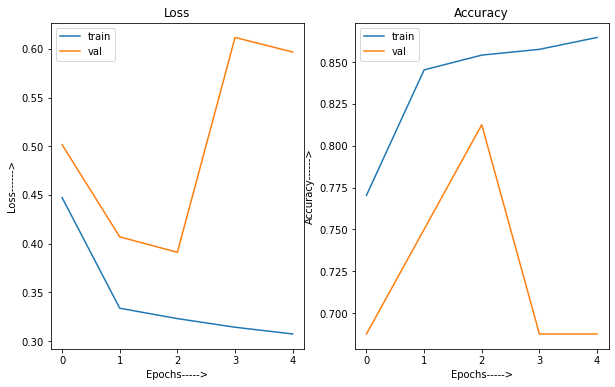

In [15]:
df=pd.DataFrame(history.history)
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(df[['loss','val_loss']])
plt.xlabel("Epochs----->")
plt.ylabel("Loss------>")
plt.legend(['train','val'])
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(df[['accuracy','val_accuracy']])
plt.xlabel("Epochs----->")
plt.ylabel("Accuracy------>")
plt.legend(['train','val'])
plt.title("Accuracy")

# Utility Functions for Metrics and Plots

In [16]:
def plotCorrelationMatrix(df, graphWidth):
    filename = "pneumonia_detection"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

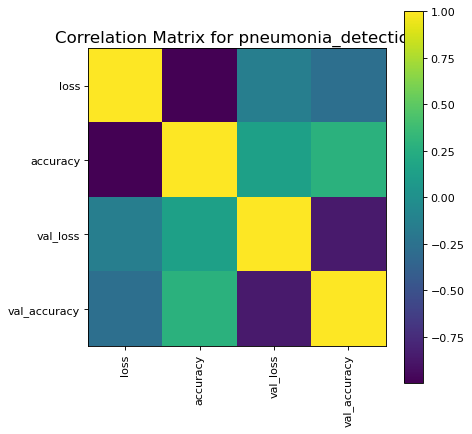

In [17]:
plotCorrelationMatrix(df,6)

In [18]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

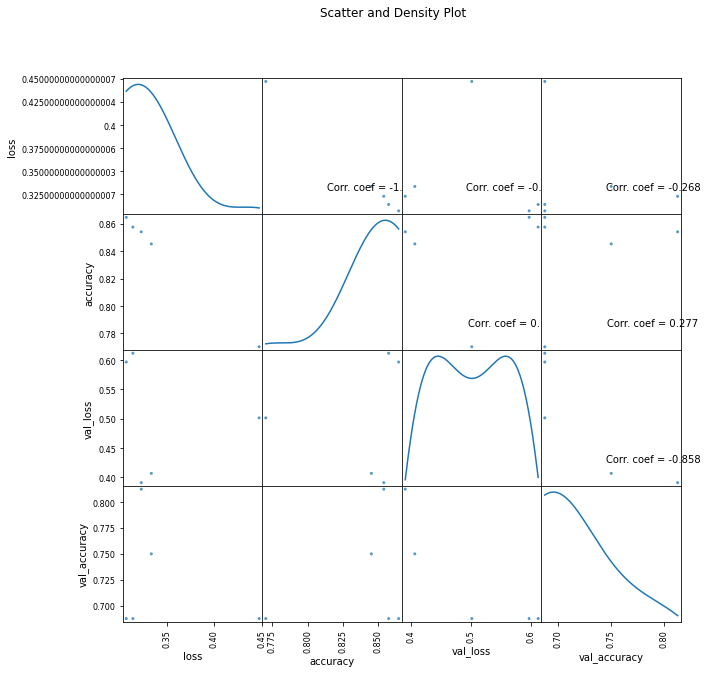

In [19]:
plotScatterMatrix(df,10,10)

In [20]:
model_Incep.evaluate(test_data)

20/20 [==============================] - 153s 7s/step - loss: 0.4538 - accuracy: 0.7853


[0.45379799604415894, 0.7852563858032227]

## Prediction

1/1 [==============================] - 0s 247ms/step


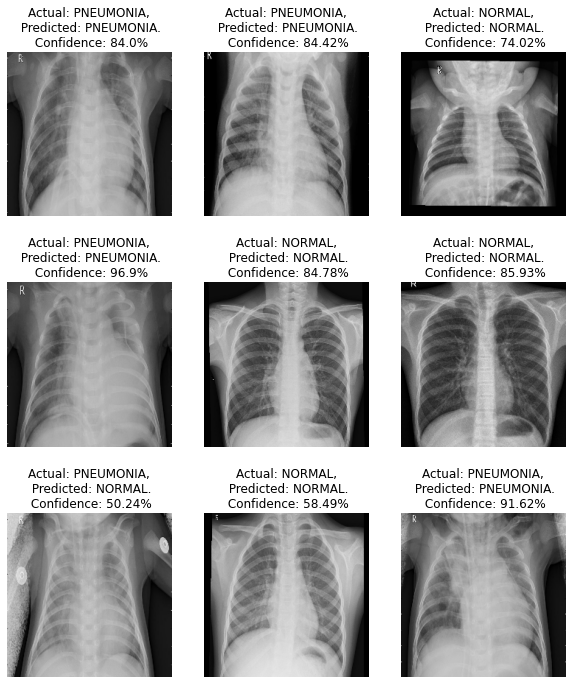

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

import numpy as np
plt.figure(figsize=(10, 12))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model_Incep, images[i].numpy())
        actual_class = class_names[np.argmax(labels[i])] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

1/1 [==============================] - 4s 4s/step


<AxesSubplot:>

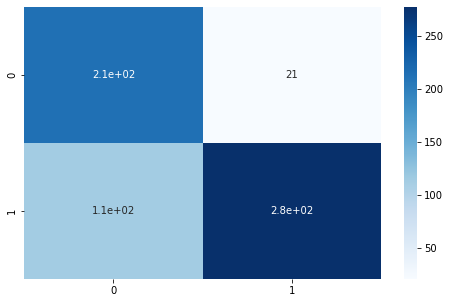

In [22]:
y_pred_vgg16=[]
y_actual_vgg16=[]
for images , labels in test_data:
    label=np.array(labels)
    pred=model_Incep.predict(images)
    for i in pred:
      y_pred_vgg16.append(np.argmax(i))
    for i in label: 
      y_actual_vgg16.append(np.argmax(i))
    
conf_mat=confusion_matrix(y_actual_vgg16,y_pred_vgg16)
import seaborn as sns
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat,annot=True,cmap="Blues")

In [23]:
print(classification_report(y_actual_vgg16,y_pred_vgg16,target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.65      0.91      0.76       234
   PNEUMONIA       0.93      0.71      0.81       390

    accuracy                           0.79       624
   macro avg       0.79      0.81      0.78       624
weighted avg       0.83      0.79      0.79       624



In [24]:
acc_vgg16 = accuracy_score(y_actual_vgg16,y_pred_vgg16) * 100
acc_vgg16

78.52564102564102

## Fine Tuning (Transfer Learning)

In [25]:
#Fine tuning
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [26]:
model_Incep.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR/10), 
                metrics=["accuracy"])

In [27]:
fine_tune_epochs = 10
total_epochs =  5 + fine_tune_epochs

history_fine = model_Incep.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_data,
                        verbose=True,
                      callbacks=[early_stopping])

Epoch 5/15
163/163 [==============================] - 1490s 9s/step - loss: 0.3074 - accuracy: 0.8610 - val_loss: 0.4053 - val_accuracy: 0.8125
Epoch 6/15
163/163 [==============================] - 1462s 9s/step - loss: 0.2879 - accuracy: 0.8731 - val_loss: 0.4469 - val_accuracy: 0.8125
Epoch 7/15
163/163 [==============================] - 1424s 9s/step - loss: 0.3011 - accuracy: 0.8677 - val_loss: 0.4236 - val_accuracy: 0.8125


In [28]:
model_Incep.evaluate(test_data)

20/20 [==============================] - 167s 8s/step - loss: 0.4398 - accuracy: 0.7965


[0.439810574054718, 0.7964743375778198]

1/1 [==============================] - 5s 5s/step


<AxesSubplot:>

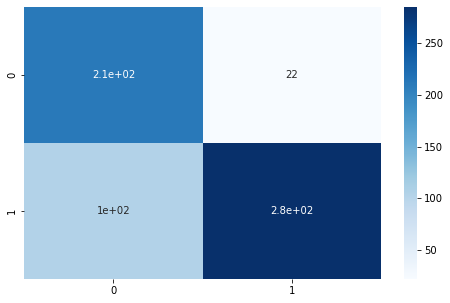

In [29]:
y_pred_fine=[]
y_actual_fine=[]
for images , labels in test_data:
    label=np.array(labels)
    pred=model_Incep.predict(images)
    for i in pred:
      y_pred_fine.append(np.argmax(i))
    for i in label: 
      y_actual_fine.append(np.argmax(i))
    
conf_mat=confusion_matrix(y_actual_fine,y_pred_fine)
import seaborn as sns
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat,annot=True,cmap="Blues")

In [30]:
print(classification_report(y_actual_fine,y_pred_fine,target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.67      0.91      0.77       234
   PNEUMONIA       0.93      0.73      0.82       390

    accuracy                           0.80       624
   macro avg       0.80      0.82      0.79       624
weighted avg       0.83      0.80      0.80       624



In [31]:
acc_fineTuning = accuracy_score(y_actual_fine,y_pred_fine) * 100
acc_fineTuning

79.6474358974359

# ResNet50

In [32]:
from keras.applications.resnet import ResNet50

model = ResNet50(weights='imagenet', include_top=False)
result = model.output
result = GlobalAveragePooling2D()(result)
result = Dense(512, activation='relu')(result)
predictions = Dense(2, activation='sigmoid')(result)
inception_transfer = Model(inputs=model.input, outputs=predictions)
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

94765736/94765736 [==============================] - 76s 1us/step


In [33]:
history = inception_transfer.fit_generator(
    train_data,
    epochs=5, 
    shuffle = True, 
    verbose = 1, 
    validation_data = valid_data)

Epoch 1/5
163/163 [==============================] - 2484s 15s/step - loss: 0.3942 - accuracy: 0.8163 - val_loss: 0.7869 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 2290s 14s/step - loss: 0.2303 - accuracy: 0.9095 - val_loss: 1.0691 - val_accuracy: 0.5625
Epoch 3/5
163/163 [==============================] - 2218s 14s/step - loss: 0.1807 - accuracy: 0.9344 - val_loss: 1.1534 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 2201s 13s/step - loss: 0.1644 - accuracy: 0.9398 - val_loss: 1.3499 - val_accuracy: 0.5625
Epoch 5/5
163/163 [==============================] - 2186s 13s/step - loss: 0.1430 - accuracy: 0.9475 - val_loss: 1.4622 - val_accuracy: 0.6250


In [34]:
inception_transfer.evaluate(test_data)

20/20 [==============================] - 78s 4s/step - loss: 0.5988 - accuracy: 0.7388


[0.5988255739212036, 0.7387820482254028]

1/1 [==============================] - 3s 3s/step


<AxesSubplot:>

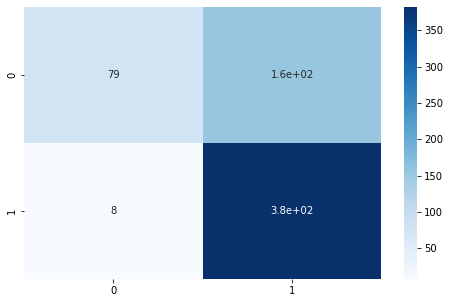

In [35]:
y_pred_res=[]
y_actual_res=[]
for images , labels in test_data:
    label=np.array(labels)
    pred=inception_transfer.predict(images)
    for i in pred:
      y_pred_res.append(np.argmax(i))
    for i in label: 
      y_actual_res.append(np.argmax(i))
    
conf_mat=confusion_matrix(y_actual_res,y_pred_res)
import seaborn as sns
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat,annot=True,cmap="Blues")

In [36]:
print(classification_report(y_actual_res,y_pred_res,target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.91      0.34      0.49       234
   PNEUMONIA       0.71      0.98      0.82       390

    accuracy                           0.74       624
   macro avg       0.81      0.66      0.66       624
weighted avg       0.79      0.74      0.70       624



In [37]:
acc_resnet = accuracy_score(y_actual_res,y_pred_res)*100
acc_resnet

73.87820512820514

# Comparison Bar Graph With VGG16 Algorithm Vs Fine Turning Vs RESNet50 Algorithm 

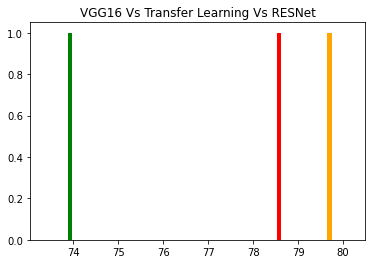

In [46]:
plt.hist(acc_vgg16,color='Red',label='VGG16')
plt.hist(acc_fineTuning,color='Orange',label='Fine Turning')
plt.hist(acc_resnet,color='Green',label='ResNet')
plt.title("VGG16 Vs Transfer Learning Vs RESNet")
plt.show()

# Comparison Pie Graph With VGG16 Algorithm Vs Fine Turning Vs RESNet50 Algorithm 

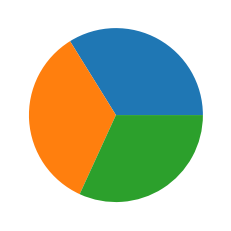

In [47]:
model = acc_vgg16,acc_fineTuning,acc_resnet
plt.pie(model)
plt.show()